<a href="https://colab.research.google.com/github/menasiraziz/IMU/blob/master/norm_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
x_d,y_d=sample_data()

In [4]:
import torch
x_data=torch.from_numpy(x_d)
m1=torch.FloatTensor(x_data.size()[0]).uniform_()<0.8
print(m1.shape)
train_set=x_data[m1]
test_set=x_data[~m1]
train_set.size()

torch.Size([99999])


torch.Size([79967, 2])

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SandTLayer(nn.Module):
    def __init__(self):
        super(SandTLayer, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10,10)
        self.fc3 = nn.Linear(10,2)
        self.prelu=nn.PReLU()
    def forward(self,x):
      #print(x)
      z=(self.fc3(torch.relu(self.fc2(torch.relu(self.fc1(x))))))
      a1=torch.tanh(z[:,0])
      a2=self.prelu(z[:,1])
      y=torch.stack([a1,a2])
      #print(a1)
      #print(a2)
      #print(y)
      return y.permute(1,0)

net=SandTLayer()
mask=torch.tensor([0,1],dtype=bool)
print(mask)
inp=torch.randn(10,2)
print(inp.shape)
out=net(inp*mask)
print(out)
print(out[:,0])

tensor([False,  True])
torch.Size([10, 2])
tensor([[-0.2798, -0.0775],
        [-0.2730, -0.0678],
        [-0.2802, -0.0776],
        [-0.2974, -0.0846],
        [-0.3052, -0.0874],
        [-0.2997, -0.0855],
        [-0.2596, -0.0688],
        [-0.2740, -0.0681],
        [-0.2883, -0.0809],
        [-0.2636, -0.0682]], grad_fn=<PermuteBackward>)
tensor([-0.2798, -0.2730, -0.2802, -0.2974, -0.3052, -0.2997, -0.2596, -0.2740,
        -0.2883, -0.2636], grad_fn=<SelectBackward>)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CouplingLayer(nn.Module):
    def __init__(self,mask):
        super(CouplingLayer, self).__init__()
        self.l=SandTLayer()
        self.b=mask
    def forward(self,x):
      mask=self.b.repeat(x.shape[0],1)
      a=self.l(x*self.b)
      y1=x[~mask]*torch.exp(a[:,0])+a[:,1]
      if(self.b[0]):
        y=torch.stack([x[mask],y1])
      else:
        y=torch.stack([y1,x[mask]])
      return (y.permute(1,0),a[:,0])
    def inverse(self,x):
      mask=self.b.repeat(x.shape[0],1)
      a=self.l(x*self.b)
      y1=(x[~mask]-a[:,1])*torch.exp(-a[:,0])
      if(self.b[0]):
        y=torch.stack([x[mask],y1])
      else:
        y=torch.stack([y1,x[mask]])
      return y.permute(1,0)



b=torch.tensor([1,0],dtype=bool)
mod=CouplingLayer(b)
a = 2*torch.randn(10,2)
print(a)
a=mod(a)
print(a)
print(mod.inverse(a[0]))

tensor([[-0.3416,  0.9077],
        [-0.3836, -0.5798],
        [ 0.4766, -0.1078],
        [-3.0206,  2.2038],
        [ 1.3335, -1.4539],
        [ 1.3321,  2.6637],
        [ 1.1967, -3.2234],
        [ 0.3160, -0.2954],
        [-3.2394, -0.4700],
        [ 0.2283,  1.1824]])
(tensor([[-0.3416,  1.4332],
        [-0.3836, -0.9745],
        [ 0.4766, -0.0846],
        [-3.0206,  5.1431],
        [ 1.3335, -2.1699],
        [ 1.3321,  4.4038],
        [ 1.1967, -4.9339],
        [ 0.3160, -0.3984],
        [-3.2394, -1.2623],
        [ 0.2283,  1.7920]], grad_fn=<PermuteBackward>), tensor([0.4776, 0.4860, 0.3964, 0.8693, 0.4679, 0.4678, 0.4539, 0.4002, 0.8872,
        0.4023], grad_fn=<SelectBackward>))
tensor([[-0.3416,  0.9077],
        [-0.3836, -0.5798],
        [ 0.4766, -0.1078],
        [-3.0206,  2.2038],
        [ 1.3335, -1.4539],
        [ 1.3321,  2.6637],
        [ 1.1967, -3.2234],
        [ 0.3160, -0.2954],
        [-3.2394, -0.4700],
        [ 0.2283,  1.1824]], grad

In [7]:

class myNet(nn.Module):
  def __init__(self):
    super(myNet,self).__init__()
    b=torch.tensor([[1,0],[0,1],[1,0],[0,1]],dtype=bool)
    self.l1 = CouplingLayer(b[0])
    self.l2 = CouplingLayer(b[1])
    self.l3 = CouplingLayer(b[2])
    self.l4 = CouplingLayer(b[3])
  
  def forward(self,x):
    x,s1=self.l1(x)
    x,s2=self.l2(x)
    x,s3=self.l3(x)
    x,s4=self.l4(x)
    y=torch.sigmoid(x)
    return (y,x,s1,s2,s3,s4)
  def inverse(self,y):
    #print(y)
    a=1-y
    #print(a)
    y=torch.log(y/(1-y))
    #print(y)
    return self.l1.inverse(self.l2.inverse(self.l3.inverse(self.l4.inverse(y))))

net = myNet()
a = torch.randn(10,2)
(y,x,s1,s2,s3,s4)=net(a)
#print(y)
print(a)
net.inverse(y)


tensor([[ 1.3648,  0.6599],
        [-1.3157,  0.5638],
        [-0.0850,  0.2427],
        [ 0.2566, -1.1430],
        [ 0.9861, -1.4380],
        [ 0.1472, -0.8074],
        [-1.3946,  0.4507],
        [-1.1728,  0.4543],
        [-0.4393, -1.6603],
        [ 0.0941,  0.3751]])


tensor([[ 1.3648,  0.6599],
        [-1.3157,  0.5638],
        [-0.0850,  0.2427],
        [ 0.2566, -1.1430],
        [ 0.9861, -1.4380],
        [ 0.1472, -0.8074],
        [-1.3946,  0.4507],
        [-1.1728,  0.4543],
        [-0.4393, -1.6603],
        [ 0.0941,  0.3751]], grad_fn=<PermuteBackward>)

In [0]:
def myloss(y,x,s1,s2,s3,s4):
  loss=2*torch.sum(F.logsigmoid(x))-torch.sum(x)+torch.sum(s1)+torch.sum(s2)+torch.sum(s3)+torch.sum(s4)
  return -loss

In [9]:
net = myNet()
(y,x,s1,s2,s3,s4)=net(train_set[:1000].float())
#myloss(x,s1,s2,s3,s4)
#torch.sum(s4)
print(myloss(y,x,s1,s2,s3,s4))

tensor(4429.6162, grad_fn=<NegBackward>)


In [13]:
import torch.optim as optim
net = myNet()
optimizer = optim.Adam(net.parameters(), lr=0.01)
for epoch in range(500):  # loop over the dataset multiple times


    optimizer.zero_grad()
    (y,x,s1,s2,s3,s4)=net(train_set.float())
    loss = myloss(y,x,s1,s2,s3,s4)/train_set.shape[0]
    loss.backward()
    optimizer.step()
    if(epoch%50==0):
      print(loss)  
    #print(loss)

print('Finished Training')

tensor(4.1243, grad_fn=<DivBackward0>)
tensor(2.8813, grad_fn=<DivBackward0>)
tensor(2.5493, grad_fn=<DivBackward0>)
tensor(2.4457, grad_fn=<DivBackward0>)
tensor(2.3918, grad_fn=<DivBackward0>)
tensor(2.3607, grad_fn=<DivBackward0>)
tensor(2.3027, grad_fn=<DivBackward0>)
tensor(2.4450, grad_fn=<DivBackward0>)
tensor(2.0729, grad_fn=<DivBackward0>)
tensor(1.6731, grad_fn=<DivBackward0>)
Finished Training


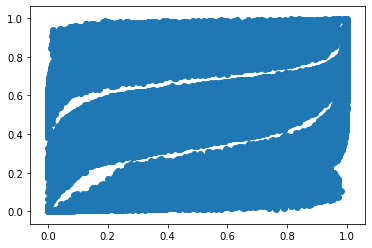

In [14]:
import matplotlib.pyplot as plt
out=y.detach().numpy()
plt.scatter(out[:,0], out[:,1])
plt.show()

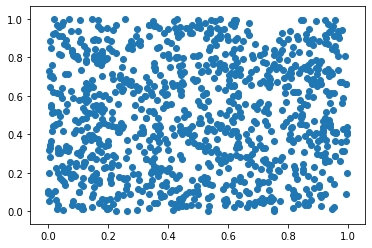

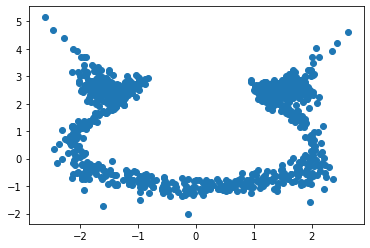

In [15]:
gen_data=torch.FloatTensor(1000,2).uniform_(0,1)
gnp=gen_data.numpy()
plt.scatter(gnp[:,0], gnp[:,1])
plt.show()
gg=net.inverse(gen_data)
gnp=gg.detach().numpy()
plt.scatter(gnp[:,0], gnp[:,1])
plt.show()